This notebook demonstrates how to load the appropriate data for different training experiments and their corresponding evaluations, once the data has been downloaded from Zenodo (see the `data_download.ipynb` notebook).

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

Before loading the data, we define a few basic functions for visualization.

In [2]:
def plot_predictor_map(predictor, var_name, domain, time_index=0, figsize=(8,8), cmap='viridis'):
    data_to_plot = predictor[var_name].isel(time=time_index)
    
    central_longitude = 180 if domain == 'NZ' else 0 if domain == 'ALPS' else None
    
    plt.figure(figsize=figsize)
    ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=central_longitude))
    
    data_to_plot.plot(ax=ax, transform=ccrs.PlateCarree(), cmap=cmap)
    
    ax.coastlines(resolution='10m')
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    
    plt.title(f'Variable {var_name} from predictor set ({domain}) for time step {time_index}')
    plt.show()

def plot_orog_map(orog, domain, figsize=(8,8), cmap='terrain'):
    data_to_plot = orog['orog']
    
    central_longitude = 180 if domain == 'NZ' else 0 if domain == 'ALPS' else None
    
    plt.figure(figsize=figsize)
    ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=central_longitude))

    if domain == 'NZ':
        data_to_plot.plot(ax=ax, transform=ccrs.PlateCarree(), cmap=cmap)
    elif domain == 'ALPS':
        cs = ax.pcolormesh(data_to_plot['lon'], data_to_plot['lat'],
                           data_to_plot,
                           transform=ccrs.PlateCarree(),
                           cmap=cmap)
    
    ax.coastlines(resolution='10m')
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    
    plt.title(f'Orography ({domain})')
    plt.show()

def plot_predictand_map(predictand, var_name, domain, time_index, figsize=(8,8), cmap='viridis'):
    data_to_plot = predictand[var_name].isel(time=time_index)
    
    central_longitude = 180 if domain == 'NZ' else 0 if domain == 'ALPS' else None
    
    plt.figure(figsize=figsize)
    ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=central_longitude))

    if domain == 'NZ':
        data_to_plot.plot(ax=ax, transform=ccrs.PlateCarree(), cmap=cmap)
    elif domain == 'ALPS':
        cs = ax.pcolormesh(data_to_plot['lon'], data_to_plot['lat'],
                           data_to_plot,
                           transform=ccrs.PlateCarree(),
                           cmap=cmap)
    
    ax.coastlines(resolution='10m')
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    
    plt.title(f'Variable {var_name} from predictand set ({domain}) for time step {time_index}')
    plt.show()

## Training Experiments

Thanks to the dataset structure across domains, loading the different experiments is quite straightforward.

In [3]:
domain = 'ALPS'
DATA_PATH = f'./data/CORDEXBench/{domain}/{domain}_domain'

Below, we can select which training experiment to load from the following options:

- ESD Pseudo Reality (`ESD_pseudo_reality`)
- Emulator (`Emulator_hist_fut`)

Depending on the selection, the code will load the corresponding predictors and predictands for the chosen experiment.

In [4]:
training_experiment = 'Emulator_hist_future'

Based on the selected experiment, we choose the appropriate period and climate model (see the tables in the README for further details), as the NetCDF files are named according to these parameters.

In [5]:
# Set the period
if training_experiment == 'ESD_pseudo_reality':
    period_training = '1961-1980'
elif training_experiment == 'Emulator_hist_future':
    period_training = '1961-1980_2080-2099'
else:
    raise ValueError('Provide a valid date')

# Set the GCM
if domain == 'ALPS':
    gcm_name = 'CNRM-CM5'
elif domain == 'NZ':
    gcm_name = 'ACCESS-CM2'

For each training experiment, we obtain a set of predictors (including orography at the predictand’s resolution) and the corresponding predictand.

The predictors consist of 15 large-scale variables representing the state of the atmosphere, with a spatial resolution of approximately 150 km and daily temporal resolution.

In [6]:
predictor_filename = f'{DATA_PATH}/train/{training_experiment}/predictors/{gcm_name}_{period_training}.nc'
predictor = xr.open_dataset(predictor_filename)

In [25]:
print(predictor)

<xarray.Dataset> Size: 225MB
Dimensions:  (time: 14610, lat: 16, lon: 16)
Coordinates:
  * time     (time) datetime64[ns] 117kB 1961-01-01T12:00:00 ... 2099-12-31T1...
  * lon      (lon) float64 128B -4.0 -2.0 0.0 2.0 4.0 ... 20.0 22.0 24.0 26.0
  * lat      (lat) float64 128B 32.0 34.0 36.0 38.0 40.0 ... 56.0 58.0 60.0 62.0
Data variables: (12/15)
    u_850    (time, lat, lon) float32 15MB ...
    u_700    (time, lat, lon) float32 15MB ...
    u_500    (time, lat, lon) float32 15MB ...
    v_850    (time, lat, lon) float32 15MB ...
    v_700    (time, lat, lon) float32 15MB ...
    v_500    (time, lat, lon) float32 15MB ...
    ...       ...
    t_850    (time, lat, lon) float32 15MB ...
    t_700    (time, lat, lon) float32 15MB ...
    t_500    (time, lat, lon) float32 15MB ...
    z_850    (time, lat, lon) float32 15MB ...
    z_700    (time, lat, lon) float32 15MB ...
    z_500    (time, lat, lon) float32 15MB ...
Attributes: (12/28)
    CDI:                            Climate Dat

The data can be easily visualized using Cartopy.

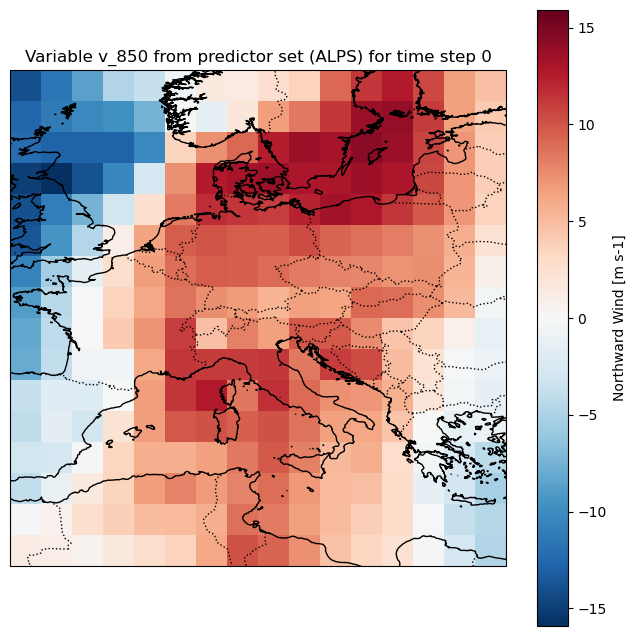

In [27]:
plot_predictor_map(predictor=predictor, var_name='v_850', domain=domain, cmap='RdBu_r')

We can also include orography as a predictor (co-variable) at the same spatial resolution as the target (~11 km).

In [11]:
orog_path =  f'{DATA_PATH}/train/{training_experiment}/predictors/Static_fields.nc'
orog = xr.open_dataset(orog_path)

if domain == 'NZ':
    orog = orog[['orog']]

In [12]:
print(orog)

<xarray.Dataset> Size: 330kB
Dimensions:  (y: 128, x: 128)
Coordinates:
    lon      (y, x) float64 131kB ...
    lat      (y, x) float64 131kB ...
  * x        (x) float64 1kB 2.062e+03 2.075e+03 ... 3.638e+03 3.65e+03
  * y        (y) float64 1kB 1.412e+03 1.425e+03 1.438e+03 ... 2.988e+03 3e+03
Data variables:
    orog     (y, x) float32 66kB ...
Attributes: (12/26)
    description:                    Created by xios
    title:                          Created by xios
    Conventions:                    CF-1.6
    creation_date:                  2018-11-12T08:28:52Z
    tracking_id:                    hdl:21.14103/30495a86-afa0-43d6-9017-fa76...
    name:                           EUR-11_CNRM-CERFACS-CNRM-CM5_historical_r...
    ...                             ...
    CORDEX_domain:                  EUR-11
    references:                     http://www.umr-cnrm.fr/spip.php?article12...
    comment:                        CORDEX Europe EUR-11 CNRM-ALADIN 6.3 L91 ...
    c3s_disclaime

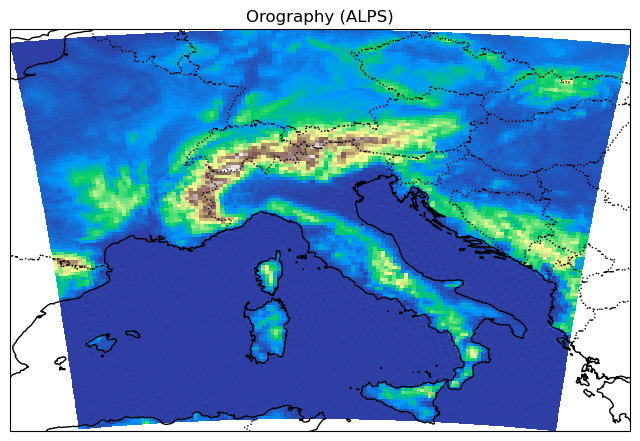

In [11]:
plot_orog_map(orog=orog, domain=domain)

Finally, we can load the predictand, which is the data used as the target. The same NetCDF file contains both variables considered as predictands in this benchmark: daily maximum temperature (tasmax) and precipitation (pr).

In [13]:
predictand_filename = f'{DATA_PATH}/train/{training_experiment}/target/pr_tasmax_{gcm_name}_{period_training}.nc'
predictand = xr.open_dataset(predictand_filename)

In [14]:
print(predictand)

<xarray.Dataset> Size: 2GB
Dimensions:  (time: 14610, y: 128, x: 128)
Coordinates:
  * time     (time) datetime64[ns] 117kB 1961-01-01T12:00:00 ... 2099-12-31T1...
    lon      (y, x) float64 131kB ...
    lat      (y, x) float64 131kB ...
  * x        (x) float64 1kB 2.062e+03 2.075e+03 ... 3.638e+03 3.65e+03
  * y        (y) float64 1kB 1.412e+03 1.425e+03 1.438e+03 ... 2.988e+03 3e+03
Data variables:
    tasmax   (time, y, x) float32 957MB ...
    pr       (time, y, x) float32 957MB ...
Attributes: (12/26)
    description:                    Created by xios
    title:                          Created by xios
    Conventions:                    CF-1.6
    creation_date:                  2018-10-24T11:26:47Z
    name:                           EUR-11_CNRM-CERFACS-CNRM-CM5_historical_r...
    institute_id:                   CNRM
    ...                             ...
    references:                     http://www.umr-cnrm.fr/spip.php?article12...
    comment:                        CO

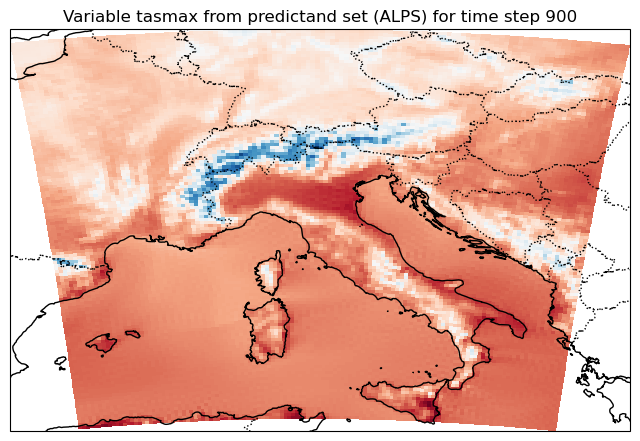

In [20]:
plot_predictand_map(predictand=predictand, var_name='tasmax', time_index=900, domain=domain, cmap='RdBu_r')

Unlike the NZ domain, for the ALPS domain the predictand simulations are provided on a curvilinear Lambert projection, which affects the visualization in Cartopy. However, the data can still be used for model training without additional processing, as it remains a square array. This ensures that models can be trained in the same way regardless of the domain.

In the following cell, we visualize the raw NumPy array for the ALPS domain.

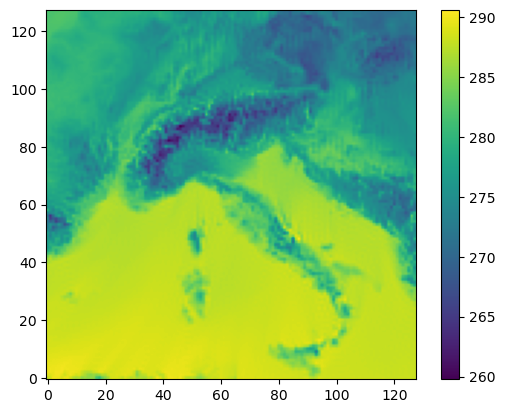

In [15]:
if domain == 'ALPS':
    predictand_tasmax_array = predictand['tasmax'].values
    plt.imshow(predictand_tasmax_array[0, :], origin='lower')
    plt.colorbar()
    plt.show()
else:
    raise ValueError('This cell requires the ALPS domain')

## Evaluation Experiments

Similarly to the training data, the evaluation data for the different experiments can be loaded in the same format with ease. We follow the same naming convention for evaluation experiments as provided in the tables of the README. In the following cell we specify which evaluation experiment to load.

In [21]:
evaluation_experiment = 'Extrapolation_imperfect'

Below, we define the data to be loaded for each evaluation experiment.

In [22]:
# Define experiment settings
evaluation_experiment_settings = {
    "ESD_pseudo_reality": {
        "PP_cross_validation": ("historical", "perfect", True),
        "Imperfect_cross_validation": ("historical", "imperfect", True),
        "Extrapolation_perfect": ("mid_end_century", "perfect", True),
        "Extrapolation_imperfect": ("mid_end_century", "imperfect", True),
    },
    "Emulator_hist_future": {
        "PP_cross_validation": ("historical", "perfect", True),
        "Imperfect_cross_validation": ("historical", "imperfect", True),
        "Extrapolation_perfect": ("mid_end_century", "perfect", True),
        "Extrapolation_perfect_hard": ("mid_end_century", "perfect", False),
        "Extrapolation_imperfect_hard": ("mid_end_century", "imperfect", False),
    },
}

# Get settings for the chosen experiments
period, mode, same_gcm_as_train = evaluation_experiment_settings[training_experiment][evaluation_experiment]

In [23]:
# Map periods to dates
period_dates = {
    "historical": "1981-2000",
    "mid_century": "2041-2060",
    "end_century": "2080-2099",
    "mid_end_century": ["2041-2060", "2080-2099"],
}

period_date = period_dates[period]

In [24]:
# GCM selection by domain and training setup
gcm_train = {"NZ": "ACCESS-CM2", "ALPS": "CNRM-CM5"}
gcm_eval = {"NZ": "EC-Earth3", "ALPS": "MPI-ESM-LR"}

if same_gcm_as_train:
    gcm_name = gcm_train[domain]
else:
    gcm_name = gcm_eval[domain]

With the option set, we can proceed to load the corresponding predictor data.

In [27]:
if period == 'mid_end_century':
    predictor_evaluation_filename_mid_century = f'{DATA_PATH}/test/mid_century/predictors/{mode}/{gcm_name}_2041-2060.nc'
    predictor_evaluation_mid = xr.open_dataset(predictor_evaluation_filename_mid_century)
    
    predictor_evaluation_filename_end_century = f'{DATA_PATH}/test/end_century/predictors/{mode}/{gcm_name}_2080-2099.nc'
    predictor_evaluation_end = xr.open_dataset(predictor_evaluation_filename_end_century)

    predictor_evaluation = xr.merge([predictor_evaluation_mid, predictor_evaluation_end])
else:
    predictor_evaluation_filename = f'{DATA_PATH}/test/{period}/predictors/{mode}/{gcm_name}_{period_date}.nc'
    predictor_evaluation = xr.open_dataset(predictor_evaluation_filename)

In [28]:
print(predictor_evaluation)

<xarray.Dataset> Size: 225MB
Dimensions:  (time: 14610, lat: 16, lon: 16)
Coordinates:
  * time     (time) datetime64[ns] 117kB 2041-01-01T12:00:00 ... 2099-12-31T1...
  * lat      (lat) float64 128B 32.0 34.0 36.0 38.0 40.0 ... 56.0 58.0 60.0 62.0
  * lon      (lon) float64 128B -4.0 -2.0 0.0 2.0 4.0 ... 20.0 22.0 24.0 26.0
Data variables: (12/15)
    u_850    (time, lat, lon) float32 15MB 0.6979 1.006 0.9772 ... -7.268 -7.166
    u_700    (time, lat, lon) float32 15MB 6.453 5.366 4.418 ... -3.908 -4.705
    u_500    (time, lat, lon) float32 15MB 11.07 8.9 7.059 ... 9.424 7.84 5.133
    v_850    (time, lat, lon) float32 15MB 4.001 5.376 5.82 ... 4.562 2.862
    v_700    (time, lat, lon) float32 15MB 6.743 6.337 5.316 ... 0.7572 0.7276
    v_500    (time, lat, lon) float32 15MB 4.185 1.784 -0.2295 ... -14.96 -14.33
    ...       ...
    z_850    (time, lat, lon) float32 15MB 1.586e+03 1.591e+03 ... 1.442e+03
    z_700    (time, lat, lon) float32 15MB 3.18e+03 3.186e+03 ... 2.904e+03
  

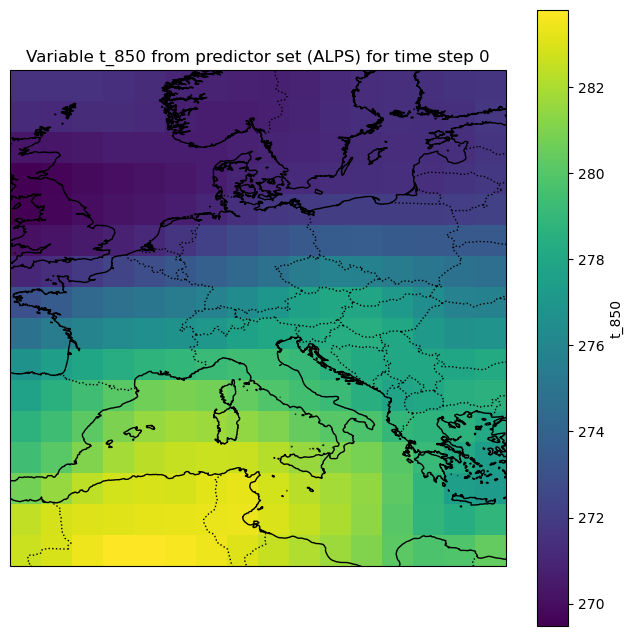

In [29]:
plot_predictor_map(predictor=predictor_evaluation, var_name='t_850', domain=domain)